# Train Model

In [8]:
import os
import cv2
import json
import numpy as np
import mediapipe as mp
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

In [9]:
hands = mp.solutions.hands.Hands()
                
def get_hands_landmarks(frame):
    results = hands.process(frame)
    landmarks = np.zeros((42, 3))
    if results.multi_hand_landmarks:
        for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
            if results.multi_handedness[i].classification[0].index == 0: 
                landmarks[:21, :] = np.array(
                    [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
            else:
                landmarks[21:, :] = np.array(
                    [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left
    return landmarks

In [10]:
def encode_data(dataset_path, output_path):
    dataset = []
    labels = []
    os.makedirs(output_path, exist_ok=True)
    mapping_path = os.path.join(output_path, 'label_mapping.json')

    if os.path.exists(mapping_path):
        with open(mapping_path, 'r') as f:
            label_mapping = json.load(f)
    else:
        label_mapping = {}
        
    for label in os.listdir(dataset_path):
        if label not in label_mapping:
            label_mapping[label] = len(label_mapping)
            
    with open(mapping_path, 'w') as f:
        json.dump(label_mapping, f)
        
    for label in os.listdir(dataset_path):
        for filename in os.listdir(os.path.join(dataset_path, label)):
            frame = cv2.imread(os.path.join(dataset_path, label, filename))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            landmarks = get_hands_landmarks(frame)
            if np.all(landmarks == 0):
                continue
            dataset.append(landmarks)
            labels.append(label_mapping[label])
            
    dataset = np.array(dataset)
    labels = np.array(labels)
    np.save(os.path.join(output_path, 'dataset.npy'), dataset)
    np.save(os.path.join(output_path, 'labels.npy'), labels)
    
encode_data('../Dataset', '../Encoded Data')

In [11]:
def load_data(data_path):
    dataset = np.load(os.path.join(data_path, 'dataset.npy'))
    labels = np.load(os.path.join(data_path, 'labels.npy'))
    label_mapping = json.load(open(os.path.join(data_path, 'label_mapping.json'), 'r'))
    return dataset, labels, label_mapping

X, y, label_mapping = load_data('../Encoded Data')
num_classes = len(label_mapping)
print(X.shape, y.shape, num_classes)

(352, 42, 3) (352,) 8


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(281, 42, 3) (281,) (71, 42, 3) (71,)


In [26]:
tf.keras.backend.clear_session()

base_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(42, 3)),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu')
], name='base_model')

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(42, 3)),
    base_model,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
print("Base Model Summary:\n")
base_model.summary()
print("\n" + "-"*70)
print("Model Summary:\n")
model.summary()

Base Model Summary:

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            320       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None,

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=100,
                                                  restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=500,
                    callbacks=[early_stopping])

Epoch 1/500
9/9 [==============================] - 3s 64ms/step - loss: 2.0801 - accuracy: 0.1103 - val_loss: 2.0692 - val_accuracy: 0.1972
Epoch 2/500
9/9 [==============================] - 0s 11ms/step - loss: 2.0717 - accuracy: 0.1032 - val_loss: 2.0731 - val_accuracy: 0.1408
Epoch 3/500
9/9 [==============================] - 0s 11ms/step - loss: 2.0566 - accuracy: 0.1601 - val_loss: 2.0734 - val_accuracy: 0.1268
Epoch 4/500
9/9 [==============================] - 0s 10ms/step - loss: 2.0508 - accuracy: 0.1744 - val_loss: 2.0909 - val_accuracy: 0.0986
Epoch 5/500
9/9 [==============================] - 0s 12ms/step - loss: 2.0453 - accuracy: 0.1851 - val_loss: 2.0773 - val_accuracy: 0.1408
Epoch 6/500
9/9 [==============================] - 0s 11ms/step - loss: 2.0452 - accuracy: 0.1637 - val_loss: 2.0795 - val_accuracy: 0.1268
Epoch 7/500
9/9 [==============================] - 0s 13ms/step - loss: 2.0289 - accuracy: 0.1566 - val_loss: 2.0836 - val_accuracy: 0.1268
Epoch 8/500
9/9 [===

In [29]:
model.evaluate(X_train, y_train)

9/9 [==============================] - 0s 4ms/step - loss: 0.0790 - accuracy: 0.9751


[0.07900921255350113, 0.9750889539718628]

In [30]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.8086 - accuracy: 0.8451


[0.8085650205612183, 0.8450704216957092]

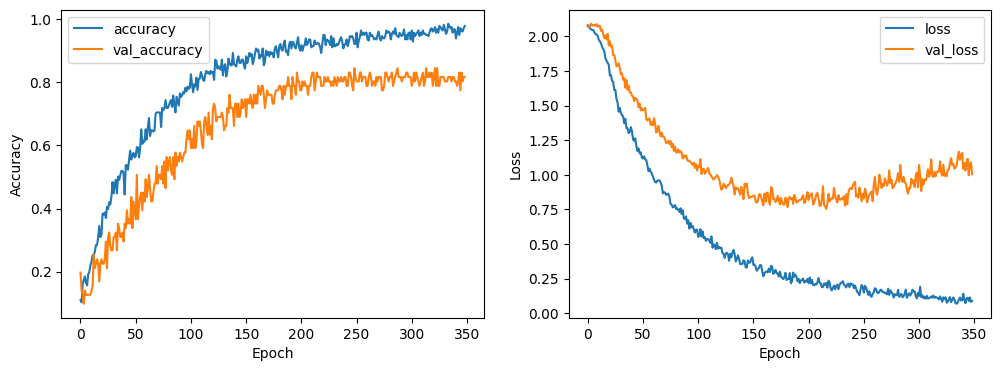

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
os.makedirs('../Models', exist_ok=True)
model.save('../Models/model.keras')
base_model.save('../Models/base.keras')

---